In [2]:
import os

os.environ['POLARS_MAX_THREADS'] = '16'

import polars as pl
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

np.random.seed(1234)

In [11]:
gdf_kom = gpd.read_file('data/au_inspire.gpkg').to_crs(25832)
gdf_kom = gdf_kom[~gdf_kom['nationalcode'].str.contains('DK')].reset_index(drop=True)
gdf_kom

/home/jbh/Desktop/repos/school-boundaries/.venv/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'au_inspire.gpkg': 'administrativeunit' (default), 'administrativeboundary'. Specify layer parameter to avoid this warning.
  result = read_func(


,nationalcode,nationallevel,inspireid,nationallevelname,beginlifespanversion,endlifespanversion,country,name_gn_language,name_gn_nativeness,name_gn_namestatus,name_gn_sourceofname,name_gn_pronunciation,name_gn_spell_spellofna_text,name_gn_spell_spellofna_script,residenceofauthority,upperlevelunit,boundary,geometry
0,0187,3rdOrder,389120,Kommune,2024-10-03 11:51:03+00:00,NaT,DK,dan,endonym,official,None,None,Vallensbæk,Latn,None,389099,None,"POLYGON ((711858.74 6172750.38, 711833.58 6172..."
1,0147,3rdOrder,389104,Kommune,2024-01-16 12:52:12+00:00,NaT,DK,dan,endonym,official,None,None,Frederiksberg,Latn,None,389099,None,"POLYGON ((722290.77 6177984.8, 722299.14 61779..."
2,0175,3rdOrder,389116,Kommune,2024-12-11 11:46:07+00:00,NaT,DK,dan,endonym,official,None,None,Rødovre,Latn,None,389099,None,"POLYGON ((716853.61 6179758.87, 716848.34 6179..."
3,0161,3rdOrder,389110,Kommune,2024-12-11 12:05:54+00:00,NaT,DK,dan,endonym,official,None,None,Glostrup,Latn,None,389099,None,"POLYGON ((714756.01 6178913.72, 714751.63 6178..."
4,0153,3rdOrder,389106,Kommune,2023-12-04 13:58:09+00:00,NaT,DK,dan,endonym,official,None,None,Brøndby,Latn,None,389099,None,"POLYGON ((716491.82 6174847.56, 716490.73 6174..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1084,2ndOrder,389099,Region,2024-10-03 14:19:16+00:00,NaT,DK,dan,endonym,official,None,None,Region Hovedstaden,Latn,None,None,None,"MULTIPOLYGON (((705749.4 6225466.94, 705748.41..."
100,1081,2ndOrder,389098,Region,2024-10-03 12:52:00+00:00,NaT,DK,dan,endonym,official,None,None,Region Nordjylland,Latn,None,None,None,"MULTIPOLYGON (((596060.05 6402306.84, 596029.9..."
101,1082,2ndOrder,389101,Region,2025-02-03 14:13:44+00:00,NaT,DK,dan,endonym,official,None,None,Region Midtjylland,Latn,None,None,None,"MULTIPOLYGON (((504089.16 6295422.32, 504088.5..."
102,1085,2ndOrder,389100,Region,2024-10-21 05:49:22+00:00,NaT,DK,dan,endonym,official,None,None,Region Sjælland,Latn,None,None,None,"MULTIPOLYGON (((641996.7 6209602.82, 641991.65..."


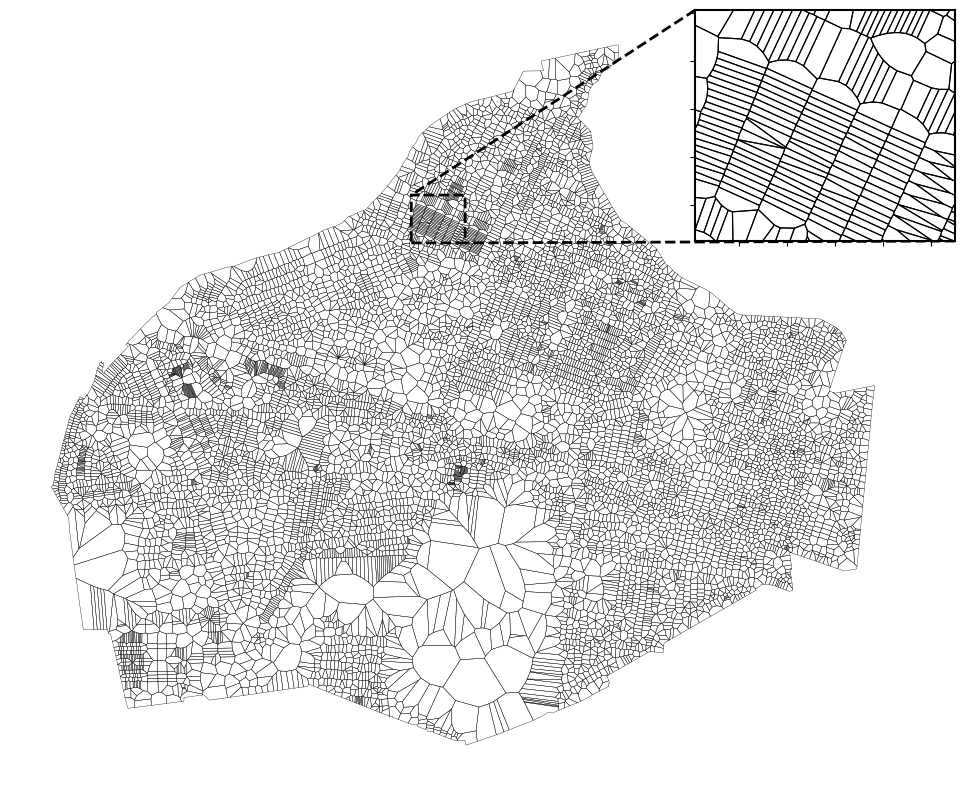

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))

gdf = gpd.read_parquet('data/dk_adresser_voronoi.pq')
gdf_kom = gdf[gdf['kommunekode']==147].reset_index(drop=True)
gdf_kom.plot(ax = ax, facecolor='none', edgecolor='k', linewidth=0.25)
ax.set_axis_off()

# Define zoom coordinates
zoom_xlim = [		721305, 		721575]
zoom_ylim = [	6177113, 	6177353]

# Create inset axes for the zoom
# [x_position, y_position, width, height] in axes coordinates (0-1)
axins = ax.inset_axes([0.75, 0.7, 0.3, 0.3])

# Filter data for the zoom area
gdf_zoom = gdf_kom.cx[zoom_xlim[0]:zoom_xlim[1], zoom_ylim[0]:zoom_ylim[1]]

# Plot the zoomed data
gdf_zoom.plot(ax=axins, facecolor='none', edgecolor='k', linewidth=0.8)

# Set the zoom limits
axins.set_xlim(zoom_xlim)
axins.set_ylim(zoom_ylim)

# Remove tick labels from inset
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a border around the inset
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Draw lines connecting the main plot to the inset
ax.indicate_inset_zoom(axins, edgecolor="k", linewidth=2, linestyle='--', alpha=1)

plt.tight_layout()
plt.show()
fig.savefig('figs/voronoi_tess_fberg.pdf', bbox_inches = 'tight')

In [ ]:
no_of_schools = 14
neighboring_adrs_to_school = 20

random_adr = gdf_kom.sample(no_of_schools, random_state=1234).reset_index(drop=True)

# remove these from df?

schools_adr = random_adr[['etrs89_east', 'etrs89_north']].to_numpy()
all_adr = gdf_kom[['etrs89_east', 'etrs89_north']].to_numpy()
kd_tree = KDTree(all_adr)
dist, idx = kd_tree.query(schools_adr, k=neighboring_adrs_to_school, workers=8)

In [74]:
gdf_kom['school_id'] = np.nan

<Axes: >

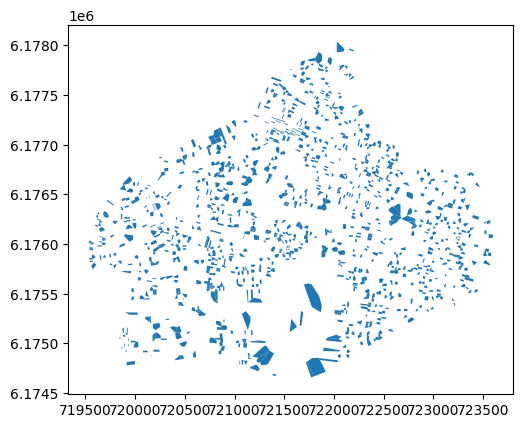

In [75]:
for i,j in enumerate(idx):
    gdf_kom.loc[idx[i], ['school_id']] = j
gdf_kom.dissolve(by = 'school_id').plot()

In [72]:
gdf_kom['school_id'].describe()

count    2836.000000
mean     4842.318406
std      2742.584153
min         2.000000
25%      2450.750000
50%      4838.500000
75%      7265.750000
max      9567.000000
Name: school_id, dtype: float64

In [66]:
gdf_kom['school_id']

0       NaN
1       NaN
2       2.0
3       NaN
4       NaN
       ... 
9564    NaN
9565    NaN
9566    NaN
9567    NaN
9568    NaN
Name: school_id, Length: 9569, dtype: float64

<Axes: >

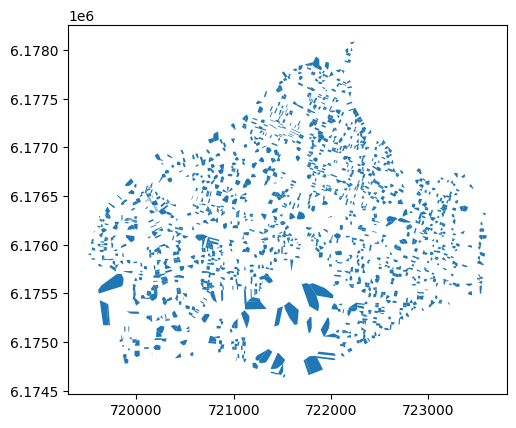